# Mean absolute error of DOS prediction with respect to variation in training set size 

In Part 3, we study how MAE of DOS prediction changes with respect to variation in training set size ([Schutt et al paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.205118)).

Import packages

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
from sklearn import metrics

/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/amoffet2/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Import featurized data

In [2]:
data = pd.read_pickle('./schutt_cutoff10_binsize20.pkl')

Drop compounds without DOS value

In [3]:
data = data.dropna(subset=['dos'])
print ("Shape of data: ", data.shape)

Shape of data:  (6174, 12085)


Count sp and spd systems

In [4]:
count = data['max_orbital'].value_counts(sort=True)

Partition compounds into sp and spd systems

In [5]:
data = data.sort_values(by=['max_orbital'])

In [6]:
systems_data = {'sp': data[:count['sp']], 'spd': data[count['sp']:]}

In [7]:
print ("Size of sp systems: ", systems_data['sp'].shape[0])
print ("Size of spd systems: ", systems_data['spd'].shape[0])

Size of sp systems:  423
Size of spd systems:  5751


Specify size of training set

In [8]:
size_sp = [10, 50] + list(np.arange(100, systems_data['sp'].shape[0] - 100, 100))
size_spd = [10, 100, 500] + list(np.arange(1000, systems_data['spd'].shape[0], 1000))

Drop unnecessary columns

In [9]:
systems_data['sp'] = systems_data['sp'].drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'volume'], 1)
systems_data['spd'] = systems_data['spd'].drop(['material_id', 'pretty_formula', 'structure', 'structure_obj',
       'composition_obj', 'max_atom_num', 'max_orbital', 'dos_obj', 'volume'], 1)

Partition sp and spd systems data into variable training and testing set sizes 
- sp system testing set size: 100 
- spd system testing set size: 500

In [10]:
sp_data = dict.fromkeys(size_sp)
spd_data = dict.fromkeys(size_spd)

In [11]:
for s in sp_data:
    sp_data[s] = dict.fromkeys(['x_train', 'y_train', 'x_test', 'y_test'])
    X, Y = systems_data['sp'].drop(['dos'], 1), systems_data['sp']['dos']
    sp_data[s]['x_train'], sp_data[s]['x_test'], sp_data[s]['y_train'], sp_data[s]['y_test'] = train_test_split(X, Y, train_size=s, test_size=100, shuffle=True)

In [12]:
for s in spd_data:
    spd_data[s] = dict.fromkeys(['x_train', 'y_train', 'x_test', 'y_test'])
    X, Y = systems_data['spd'].drop(['dos'], 1), systems_data['spd']['dos']
    spd_data[s]['x_train'], spd_data[s]['x_test'], spd_data[s]['y_train'], spd_data[s]['y_test'] = train_test_split(X, Y, train_size=s, test_size=500, shuffle=True)

Train model using training sets of different sizes

In [13]:
cv_prediction_sp = dict.fromkeys(size_sp)
for size in size_sp:
    krr = KernelRidge(kernel='laplacian', alpha=1e-5, gamma=5e-5)
    krr.fit(sp_data[size]['x_train'], sp_data[size]['y_train'])
    cv_prediction_sp[size] = cross_val_predict(krr, sp_data[size]['x_test'], sp_data[size]['y_test'], cv=KFold(5))

In [14]:
cv_prediction_spd = dict.fromkeys(size_spd)
for size in size_spd:
    krr = KernelRidge(kernel='laplacian', alpha=1e-5, gamma=5e-5)
    krr.fit(spd_data[size]['x_train'], spd_data[size]['y_train'])
    cv_prediction_spd[size] = cross_val_predict(krr, spd_data[size]['x_test'], spd_data[size]['y_test'], cv=KFold(5))

Compute aggregate statistics

In [15]:
score_sp = dict.fromkeys(size_sp)
for size in size_sp:
    score_sp[size] = dict.fromkeys(['mean_absolute_error', 'mean_squared_error', 'r2_score'])
    for scorer in ['mean_absolute_error', 'mean_squared_error', 'r2_score']:
        score_sp[size][scorer] = getattr(metrics, scorer)(sp_data[size]['y_test'], cv_prediction_sp[size])

In [16]:
score_spd = dict.fromkeys(size_spd)
for size in size_spd:
    score_spd[size] = dict.fromkeys(['mean_absolute_error', 'mean_squared_error', 'r2_score'])
    for scorer in ['mean_absolute_error', 'mean_squared_error', 'r2_score']:
        score_spd[size][scorer] = getattr(metrics, scorer)(spd_data[size]['y_test'], cv_prediction_spd[size])

In [17]:
print ("sp system score:")
for size in score_sp:
    print (size, ":", score_sp[size])
print ()
print ("spd system score:")
for size in score_spd:
    print (size, ":", score_spd[size])

sp system score:
10 : {'mean_absolute_error': 0.0014612222674057914, 'mean_squared_error': 6.629869054124286e-06, 'r2_score': -0.024597447125039418}
50 : {'mean_absolute_error': 0.0014653057114315954, 'mean_squared_error': 9.51762595937619e-06, 'r2_score': -0.05723155915317846}
100 : {'mean_absolute_error': 0.001228108666423672, 'mean_squared_error': 5.789871653011204e-06, 'r2_score': -0.11567458087009652}
200 : {'mean_absolute_error': 0.0011166860673330586, 'mean_squared_error': 4.2499341801635905e-06, 'r2_score': 0.17216017855077625}
300 : {'mean_absolute_error': 0.0023656782297544173, 'mean_squared_error': 3.872762213097659e-05, 'r2_score': -0.35024295620038326}

spd system score:
10 : {'mean_absolute_error': 0.001263425308140916, 'mean_squared_error': 3.6003529702480868e-06, 'r2_score': 0.12657397499686873}
100 : {'mean_absolute_error': 0.0011575792285383614, 'mean_squared_error': 3.0183070929944966e-06, 'r2_score': 0.10004311832920665}
500 : {'mean_absolute_error': 0.0013520738879

Plot predictions

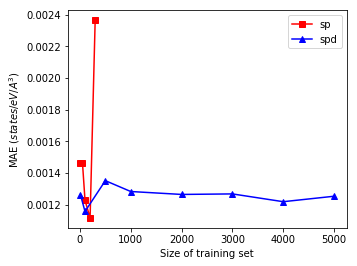

In [18]:
mae_sp = [score_sp[size]['mean_absolute_error'] for size in score_sp]
mae_spd = [score_spd[size]['mean_absolute_error'] for size in score_spd]

plt.plot(size_sp, mae_sp, color='r', marker='s', label='sp')
plt.plot(size_spd, mae_spd, color='b', marker='^', label='spd')

plt.xlabel("Size of training set")
plt.ylabel("MAE $(states/eV/A^3)$")

plt.legend()
fig = plt.gcf()
fig.set_size_inches(5,4)
